<img width="400" style="float:left" 
     src="https://as2.ftcdn.net/v2/jpg/05/63/00/99/1000_F_563009962_XqxlJbVHZQwPgIHk71I3vIa44SKCSR7w.jpg" />`

# Group Assignment MDA II - Group 1

Juliana Haddad | Bernardo Santos | Yoshiki Kitagawa | Hernan Fermin | Philippa Quadt

November 15th, 2024


This notebook is organized in the following sections:

* [Description](#0)
* [Data Preparation & Cleaning](#1)
  * [Notebook Environment Setup](#1.1)
  * [Data Source](#1.2)
  * [Data Cleaning](#1.3)
  * [Data Merging](#1.4)
  * [Preprocessing](#1.5)
  * [Handlig Null Values](#1.6)
  * [Dropping Null Values](#1.7)
* [Exploratory Data Analysis](#2) 


<a id='0'></a>
## Description

The main objective of this project is to empower streaming platforms with actionable insights into user preferences and content performance, enabling data-driven decisions for content investment and user engagement maximization.

<a id='1'></a>
## Data Preparation & Cleaning

This foundational step involves merging data, cleaning it, and preparing a single unified dataset for analysis. Proper data preparation ensures consistency and reliability for downstream analyses.

We'll use the **[Netflix, Hulu, HBO, AppleTV & Amazon dataset](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset?resource=download)** 

<a id='1.1'></a>
### Notebook Environment Setup 

As it happened with the first Spark applications we created, **we need to create a [Spark Session](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.html)** before we can specify the input source bringing the events in. The Spark Session *is the entry point to programming Spark with the DataFrame API (High-level API)*.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("StreamingServiceData").getOrCreate()

24/11/08 15:13:45 WARN Utils: Your hostname, osbdet resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s1)
24/11/08 15:13:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/08 15:13:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<a id='1.2'></a>
### Data Source

In this section, we load and inspect the CSV files using PySpark. This step ensures that data is correctly imported with inferred schemas, allowing for subsequent transformations and analyses.

In [2]:
from pyspark.sql.functions import lit

# Opening the csv files with Spark
Netflix = spark.read.csv('Netflix.csv', header=True, inferSchema=True)
Amazon = spark.read.csv('Amazon.csv', header=True, inferSchema=True)
HBO = spark.read.csv('HBO.csv', header=True, inferSchema=True)
Hulu = spark.read.csv('Hulu.csv', header=True, inferSchema=True)
AppleTV = spark.read.csv('AppleTV.csv', header=True, inferSchema=True)

In [3]:
Amazon.show(5)  # Show first 5 rows to take a look and understand the dataset 

+----+--------------+-----+--------------------+-----------+---------+-----------------+------------+--------------------+
| url|         title| type|              genres|releaseYear|   imdbId|imdbAverageRating|imdbNumVotes|  availableCountries|
+----+--------------+-----+--------------------+-----------+---------+-----------------+------------+--------------------+
|NULL|       Blondie|Movie|      Comedy, Family|       1938|tt0029927|              6.9|       885.0|              US, ZA|
|NULL|         Ariel|Movie|Comedy, Crime, Ro...|       1988|tt0094675|              7.4|      8731.0|                  JP|
|NULL|    Four Rooms|Movie|              Comedy|       1995|tt0113101|              6.7|    112456.0|              AT, DE|
|NULL|Judgment Night|Movie|Action, Crime, Drama|       1993|tt0107286|              6.6|     19258.0|                  US|
|NULL|  Forrest Gump|Movie|      Drama, Romance|       1994|tt0109830|              8.8|   2311997.0|AT, CU, DE, IN, J...|
+----+----------

<a id='1.3'></a>
### Data cleaning

Here, we clean the data by dropping unnecessary columns like 'url' and 'imdbId' that do not contribute to our analysis. Removing these columns simplifies the dataset and improves processing efficiency. To differentiate the data from various streaming platforms, we add a 'Company' column to each DataFrame. This step allows for easier filtering and analysis based on the source platform.

In [4]:
# Dropping irrelevant columns
Netflix = Netflix.drop('url', 'imdbId')
Amazon = Amazon.drop('url', 'imdbId')
HBO = HBO.drop('url', 'imdbId')
Hulu = Hulu.drop('url', 'imdbId')
AppleTV = AppleTV.drop('url', 'imdbId')

In [5]:
# Adding Company ID
Netflix = Netflix.withColumn('Company', lit('Netflix'))
Amazon = Amazon.withColumn('Company', lit('Amazon'))
HBO = HBO.withColumn('Company', lit('HBO'))
Hulu = Hulu.withColumn('Company', lit('Hulu'))
AppleTV = AppleTV.withColumn('Company', lit('AppleTV'))

<a id='1.4'></a>
### Data Merging

This section involves combining all individual DataFrames into one comprehensive DataFrame using the .union() method. We are working now with one dataset : `all_data`

In [6]:
# Combining all DataFrames into one
all_data = Netflix.union(Amazon).union(HBO).union(Hulu).union(AppleTV)

all_data.show(5)

# Saving the merged DataFrame to a new CSV file named "MergedCompany.csv"
# all_data.to_csv('MergedCompany.csv', index=False)

+-----------------+-----+--------------------+-----------+-----------------+------------+--------------------+-------+
|            title| type|              genres|releaseYear|imdbAverageRating|imdbNumVotes|  availableCountries|Company|
+-----------------+-----+--------------------+-----------+-----------------+------------+--------------------+-------+
|     Forrest Gump|Movie|      Drama, Romance|       1994|              8.8|   2311997.0|AD, AE, AG, AL, A...|Netflix|
|The Fifth Element|Movie|Action, Adventure...|       1997|              7.6|    516291.0|          AT, CH, DE|Netflix|
|Kill Bill: Vol. 1|Movie|Action, Crime, Th...|       2003|              8.2|   1219973.0|AE, AL, AO, AT, A...|Netflix|
|          Jarhead|Movie|Biography, Drama,...|       2005|                7|    211218.0|AD, AE, AG, AL, A...|Netflix|
|       Unforgiven|Movie|      Drama, Western|       1992|              8.2|    443163.0|AU, BA, BE, BG, C...|Netflix|
+-----------------+-----+--------------------+--

<a id='1.5'></a>
### Preprocessing

##### New column : `NumberofCountries`

In [7]:
from pyspark.sql.functions import when, split, size, col

# Count the number of countries in the availableCountries column
all_data = all_data.withColumn(
    "NumberOfCountries",
    when(col("availableCountries").isNotNull(), size(split(col("availableCountries"), ","))).otherwise(0)
)

# Drop the availableCountries column
all_data = all_data.drop("availableCountries")

# Show the result
all_data.show()


+--------------------+-----+--------------------+-----------+-----------------+------------+-------+-----------------+
|               title| type|              genres|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|
+--------------------+-----+--------------------+-----------+-----------------+------------+-------+-----------------+
|        Forrest Gump|Movie|      Drama, Romance|       1994|              8.8|   2311997.0|Netflix|              115|
|   The Fifth Element|Movie|Action, Adventure...|       1997|              7.6|    516291.0|Netflix|                3|
|   Kill Bill: Vol. 1|Movie|Action, Crime, Th...|       2003|              8.2|   1219973.0|Netflix|               67|
|             Jarhead|Movie|Biography, Drama,...|       2005|                7|    211218.0|Netflix|              122|
|          Unforgiven|Movie|      Drama, Western|       1992|              8.2|    443163.0|Netflix|               16|
|Eternal Sunshine ...|Movie|Drama, Romance, S...

##### New column : `ReleaseYear` & `ReleaseDecade`

In [8]:
# 
from pyspark.sql.functions import to_date, year, col, when

# Convert releaseYear to date format and extract only the year
all_data = all_data.withColumn(
    "releaseYear", 
    when(col("releaseYear").isNotNull(), year(to_date(col("releaseYear").cast("string"), "yyyy"))).cast("int")
)

# Show the result
all_data.show()


+--------------------+-----+--------------------+-----------+-----------------+------------+-------+-----------------+
|               title| type|              genres|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|
+--------------------+-----+--------------------+-----------+-----------------+------------+-------+-----------------+
|        Forrest Gump|Movie|      Drama, Romance|       1994|              8.8|   2311997.0|Netflix|              115|
|   The Fifth Element|Movie|Action, Adventure...|       1997|              7.6|    516291.0|Netflix|                3|
|   Kill Bill: Vol. 1|Movie|Action, Crime, Th...|       2003|              8.2|   1219973.0|Netflix|               67|
|             Jarhead|Movie|Biography, Drama,...|       2005|                7|    211218.0|Netflix|              122|
|          Unforgiven|Movie|      Drama, Western|       1992|              8.2|    443163.0|Netflix|               16|
|Eternal Sunshine ...|Movie|Drama, Romance, S...

In [9]:
from pyspark.sql.functions import floor, col, concat, lit

# Create the releaseDecade column by bucketing releaseYear into decades
all_data = all_data.withColumn(
    "releaseDecade", 
    concat((floor(col("releaseYear") / 10) * 10).cast("string"), lit("s"))
)

# Show the result
all_data.select("releaseYear", "releaseDecade").show()

+-----------+-------------+
|releaseYear|releaseDecade|
+-----------+-------------+
|       1994|        1990s|
|       1997|        1990s|
|       2003|        2000s|
|       2005|        2000s|
|       1992|        1990s|
|       2004|        2000s|
|       2000|        2000s|
|       2005|        2000s|
|       1968|        1960s|
|       2002|        2000s|
|       2002|        2000s|
|       2005|        2000s|
|       2004|        2000s|
|       2000|        2000s|
|       1998|        1990s|
|       2005|        2000s|
|       1996|        1990s|
|       1995|        1990s|
|       2000|        2000s|
|       2002|        2000s|
+-----------+-------------+
only showing top 20 rows



##### Genre Cleaning (dividing into extra genres, NEG)

To better analyze genre data, this section splits the 'genres' column into separate columns (e.g., 'genre1', 'genre2', 'genre3'). Any null values in these new columns are replaced with 'NEG' to indicate no genre classification, allowing the model to handle missing information effectively.

In [10]:
from pyspark.sql.functions import split, col

# Split the genres column into three separate columns
all_data = all_data.withColumn("genre1", split(col("genres"), ",").getItem(0)) \
                   .withColumn("genre2", split(col("genres"), ",").getItem(1)) \
                   .withColumn("genre3", split(col("genres"), ",").getItem(2))

# Drop the original genres column if it's no longer needed
all_data = all_data.drop("genres")

# Replace null values in genre1, genre2, and genre3 with 'NEG'
all_data = all_data.fillna({"genre1": "NEG", "genre2": "NEG", "genre3": "NEG"})

# Show the result
all_data.show()

#Checking for errors in genre 3

# Filter rows where genre3 has more than one genre (indicated by a comma)
rows_with_multi_genre_in_genre3 = all_data.filter(col("genre3").contains(","))

# Show the result
print("Rows where genre3 has more than one genre:")
rows_with_multi_genre_in_genre3.show()

+--------------------+-----+-----------+-----------------+------------+-------+-----------------+-------------+---------+----------+---------+
|               title| type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|   genre1|    genre2|   genre3|
+--------------------+-----+-----------+-----------------+------------+-------+-----------------+-------------+---------+----------+---------+
|        Forrest Gump|Movie|       1994|              8.8|   2311997.0|Netflix|              115|        1990s|    Drama|   Romance|      NEG|
|   The Fifth Element|Movie|       1997|              7.6|    516291.0|Netflix|                3|        1990s|   Action| Adventure|   Sci-Fi|
|   Kill Bill: Vol. 1|Movie|       2003|              8.2|   1219973.0|Netflix|               67|        2000s|   Action|     Crime| Thriller|
|             Jarhead|Movie|       2005|                7|    211218.0|Netflix|              122|        2000s|Biography|     Drama|      War|

##### OHE Column `type`

This section encodes the 'type' column, transforming categorical data into numerical data by mapping 'Movie' as 1 and 'TV Series' as 0. This step is essential for any subsequent machine learning models requiring numerical inputs.

In [11]:
from pyspark.sql import functions as F

# Count the number of occurrences of each unique type
type_counts = all_data.groupBy("type").count()
print("Number of different types:")
type_counts.show()

Number of different types:
+-------------+-----+
|         type|count|
+-------------+-----+
| "" Princess"|    3|
|    TV Series|24256|
|        Movie|66243|
+-------------+-----+



In [12]:
from pyspark.sql.functions import when

# Encode the 'type' column: Movie = 1, TV Series = 0
all_data = all_data.withColumn("type", when(col("type") == "Movie", 1).otherwise(0))

# Show the result
all_data.show()

+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+---------+----------+---------+
|               title|type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|   genre1|    genre2|   genre3|
+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+---------+----------+---------+
|        Forrest Gump|   1|       1994|              8.8|   2311997.0|Netflix|              115|        1990s|    Drama|   Romance|      NEG|
|   The Fifth Element|   1|       1997|              7.6|    516291.0|Netflix|                3|        1990s|   Action| Adventure|   Sci-Fi|
|   Kill Bill: Vol. 1|   1|       2003|              8.2|   1219973.0|Netflix|               67|        2000s|   Action|     Crime| Thriller|
|             Jarhead|   1|       2005|                7|    211218.0|Netflix|              122|        2000s|Biography|     Drama|      War|
|     

<a id='1.6'></a>
### Handling Null Values

Handling missing data is crucial for accurate analysis. This part checks for null values in the merged dataset and identifies nulls within each streaming platform's data. Understanding where nulls exist helps inform decisions about data cleaning strategies.

In [13]:
from pyspark.sql.functions import col, sum

# Checking for null values in each column in the merged DataFrame
null_counts = all_data.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in all_data.columns])
null_counts.show()

# In the section below, we analyze the null values for each company to check if there is any unbalance 
#  Finding null values for AppleTV
apple_tv_nulls = all_data.filter(all_data.Company == 'AppleTV').select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in all_data.columns]
)
apple_tv_nulls.show()

# Count rows in AppleTV data
num_rows_apple_tv = all_data.filter(all_data.Company == 'AppleTV').count()
print("Number of rows in AppleTV data:", num_rows_apple_tv)

from pyspark.sql.functions import col, sum

# Finding null values for Hulu
Hulu_nulls = all_data.filter(all_data.Company == 'Hulu').select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in all_data.columns]
)
print("Null values in Hulu data:")
Hulu_nulls.show()

# Count rows in Hulu data
num_rows_Hulu = all_data.filter(all_data.Company == 'Hulu').count()
print("Number of rows in Hulu data:", num_rows_Hulu)

# Finding null values for Netflix
Netflix_nulls = all_data.filter(all_data.Company == 'Netflix').select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in all_data.columns]
)
print("Null values in Netflix data:")
Netflix_nulls.show()

# Count rows in Netflix data
num_rows_Netflix = all_data.filter(all_data.Company == 'Netflix').count()
print("Number of rows in Netflix data:", num_rows_Netflix)

from pyspark.sql.functions import col, sum

# Finding null values for Amazon
Amazon_nulls = all_data.filter(all_data.Company == 'Amazon').select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in all_data.columns]
)
print("Null values in Amazon data:")
Amazon_nulls.show()

# Count rows in Amazon data
num_rows_Amazon = all_data.filter(all_data.Company == 'Amazon').count()
print("Number of rows in Amazon data:", num_rows_Amazon)

# Finding null values for HBO
HBO_nulls = all_data.filter(all_data.Company == 'HBO').select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in all_data.columns]
)
print("Null values in HBO data:")
HBO_nulls.show()

# Count rows in HBO data
num_rows_HBO = all_data.filter(all_data.Company == 'HBO').count()
print("Number of rows in HBO data:", num_rows_HBO)


# Filter AppleTV data and count rows where all three columns are null
all_three_null = all_data.filter(
    (col("Company") == "AppleTV") & 
    col("title").isNull() & 
    col("imdbAverageRating").isNull() & 
    col("imdbNumVotes").isNull()
).count()

print("Number of rows in AppleTV data where title, imdbAverageRating, and imdbNumVotes are all null:", all_three_null)

+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+
|title|type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|genre1|genre2|genre3|
+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+
| 3685|   0|        192|             6034|        6034|      0|                0|          192|     0|     0|     0|
+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+

+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+
|title|type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|genre1|genre2|genre3|
+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+
|  519|   0|         22|             1011|        1011|      0|

<a id='1.7'></a>
### Dropping Null Values

In [14]:
from pyspark.sql.functions import col, sum

# Drop rows with null values in specific columns
all_data = all_data.dropna(subset=['title', 'genre1', 'genre2', 'genre3', 'releaseYear', 'imdbAverageRating', 'imdbNumVotes'])

# Checking for null values in each column
null_counts = all_data.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in all_data.columns])
print("Null values in each numeric column:")
null_counts.show()

Null values in each numeric column:
+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+
|title|type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|genre1|genre2|genre3|
+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+
|    0|   0|          0|                0|           0|      0|                0|            0|     0|     0|     0|
+-----+----+-----------+-----------------+------------+-------+-----------------+-------------+------+------+------+



<a id='2'></a>
## ⁠Explanatory Data Analysis

##### 1. Distribution of IMDb Average Ratings (2000-2024)

This section visualizes the distribution of IMDb ratings for content released between 2000 and 2024. The histogram helps identify the most common rating range and highlight any skewness or outliers in the data. Insights from this analysis can guide understanding of audience reception trends over time and the consistency of rating quality across different years.

The chart indicates a steady increase in the average IMDb rating of movies over time, with a notable improvement starting around 2015. This suggests that the quality of movies, as perceived by viewers, has generally improved over the years, particularly in recent years

Platforms should consider investing in more recent, high-quality productions that align with the upward trend in ratings. This could mean focusing on newer releases that are already receiving positive feedback or working with production studios that have consistently delivered high-rated content. 

<Figure size 1200x600 with 0 Axes>

<BarContainer object of 25 artists>

Text(0.5, 0, 'Release Year')

Text(0, 0.5, 'Average IMDb Rating')

Text(0.5, 1.0, 'Average IMDb Rating per Year (2000 – 2024)')

(5.0, 10.0)

(array([1995., 2000., 2005., 2010., 2015., 2020., 2025., 2030.]),
 [Text(1995.0, 0, '1995'),
  Text(2000.0, 0, '2000'),
  Text(2005.0, 0, '2005'),
  Text(2010.0, 0, '2010'),
  Text(2015.0, 0, '2015'),
  Text(2020.0, 0, '2020'),
  Text(2025.0, 0, '2025'),
  Text(2030.0, 0, '2030')])

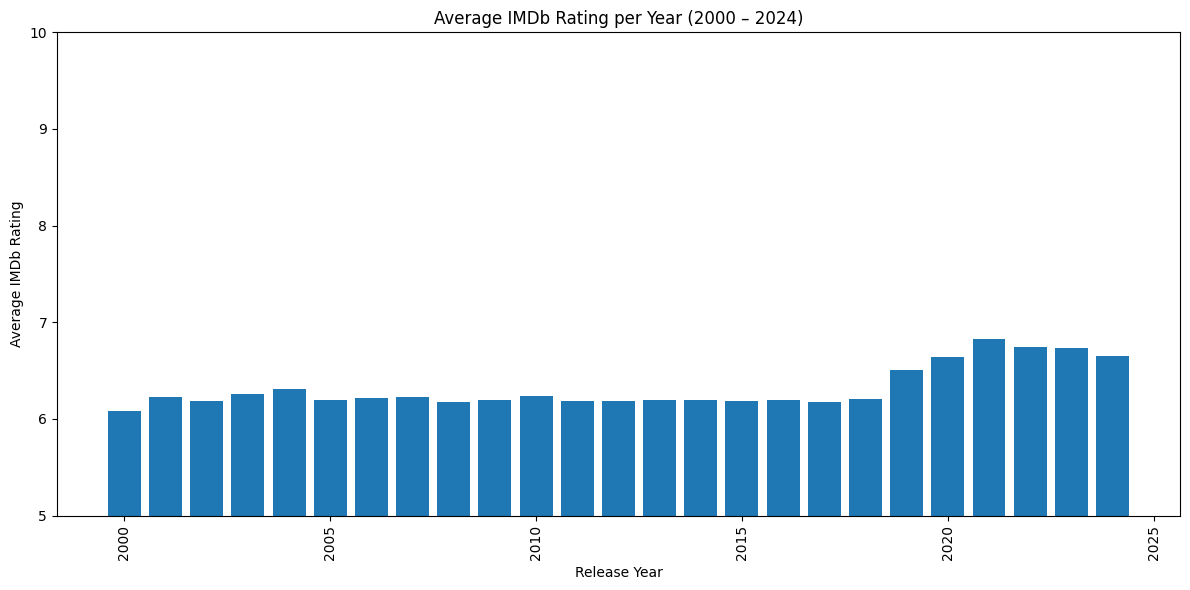

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg

# Filter and aggregate data in PySpark
filtered_data = all_data.filter((col("releaseYear") >= 2000) & (col("releaseYear") <= 2024)) \
                        .groupBy("releaseYear") \
                        .agg(avg("imdbAverageRating").alias("averageIMDbRating")) \
                        .orderBy("releaseYear")

# Convert to pandas for plotting
filtered_data_pd = filtered_data.toPandas()

# Plotting with matplotlib
plt.figure(figsize=(12, 6))
plt.bar(filtered_data_pd['releaseYear'], filtered_data_pd['averageIMDbRating'], width=0.8)

# Customizing the plot
plt.xlabel('Release Year')
plt.ylabel('Average IMDb Rating')
plt.title('Average IMDb Rating per Year (2000 – 2024)')
plt.ylim(5, 10)  # Set y-axis limit to 10
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### 2. Unique Genres Analysis

The total number of unique genres can indicate the extent of genre coverage and niche content that platforms may cater to. This data helps identify content gaps or areas for potential expansion.

The analysis identified 32 unique genres within the dataset. This diversity of genres highlights the range of content that platforms currently offer, from popular genres like Drama and Comedy to niche categories such as Game-Show and Biography. The variety suggests that platforms aim to cater to a broad audience with varied preferences.

Platforms should evaluate which of these genres attract the highest engagement and ratings. Investing in underrepresented but emerging genres could help capture niche audiences and create differentiation from competitors.

In [19]:
# Get unique genres in genre1
unique_genres_genre1 = all_data.select("genre1").distinct()

# Count the number of unique genres in genre1
num_unique_genres_genre1 = unique_genres_genre1.count()

# Show the unique genres
print("Unique genres in genre1:")
unique_genres_genre1.show()

# Print the total count of unique genres
print("Total number of unique genres in genre1:", num_unique_genres_genre1)


Unique genres in genre1:
+-----------+
|     genre1|
+-----------+
|      Crime|
|    Romance|
|   Thriller|
|  Adventure|
|      Drama|
|        War|
|Documentary|
| Reality-TV|
|     Family|
|    Fantasy|
|  Game-Show|
|    History|
|    Mystery|
|    Musical|
|  Animation|
|      Music|
|     Horror|
|    Western|
|  Biography|
|     Comedy|
+-----------+
only showing top 20 rows

Total number of unique genres in genre1: 32


##### 3. Genre Occurence visualization

 By analyzing which genres are most and least represented, platforms can strategize on content curation and understand user preferences. It can also be a basis for recommendations for increasing investment in popular or emerging genres.

The pie chart shows the distribution of main genres in the dataset. The most represented genres are Comedy and Drama, each making up approximately 21.3% of the total content. Action follows at 18.4%, indicating that these genres dominate the offerings across platforms. On the other hand, genres like Documentary, Animation, Biography, and Horror have smaller shares, indicating more niche content.

Platforms should consider investing in genres like Comedy, Drama, and Action, as these are proven to attract a large audience base. However, focusing on underrepresented genres such as Documentaries and Animations could appeal to specialized audiences and differentiate the platform.

/tmp/ipykernel_1110/646646397.py:13: SettingWithCopyWarning:                    
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre1_counts_modified.loc['Others'] = genre1_counts_pd[genre1_counts_pd['count'] < threshold].sum()


<Figure size 1000x800 with 0 Axes>

([<matplotlib.patches.Wedge at 0xffff60bb3c10>,
 [Text(-0.9900236670439533, 0.479430014384627, 'Crime'),
  Text(-1.099768169288616, 0.022582599929282608, 'Adventure'),
  Text(-0.7420437487317681, -0.8120166716072427, 'Drama'),
  Text(0.15027411068314137, -1.089686969573552, 'Documentary'),
  Text(0.47856452050428333, -0.990442325284267, 'Animation'),
  Text(0.6998162833877014, -0.8486796624789736, 'Horror'),
  Text(0.8942036050058044, -0.6406246270591096, 'Biography'),
  Text(1.0841683409724931, 0.1859543181347293, 'Comedy'),
  Text(0.17095645229663323, 1.086634203132843, 'Action'),
  Text(-0.6627886331424138, 0.8779016048380428, 'Others')],
 [Text(-0.5400129092967018, 0.2615072805734329, '7.9%'),
  Text(-0.5998735468846996, 0.012317781779608695, '5.8%'),
  Text(-0.40475113567187354, -0.4429181845130414, '21.3%'),
  Text(0.08196769673625891, -0.5943747106764828, '6.7%'),
  Text(0.26103519300233635, -0.5402412683368728, '3.3%'),
  Text(0.381717972756928, -0.46291617953398556, '4.3%'),
 

Text(0.5, 1.0, 'Distribution of Main Genres')

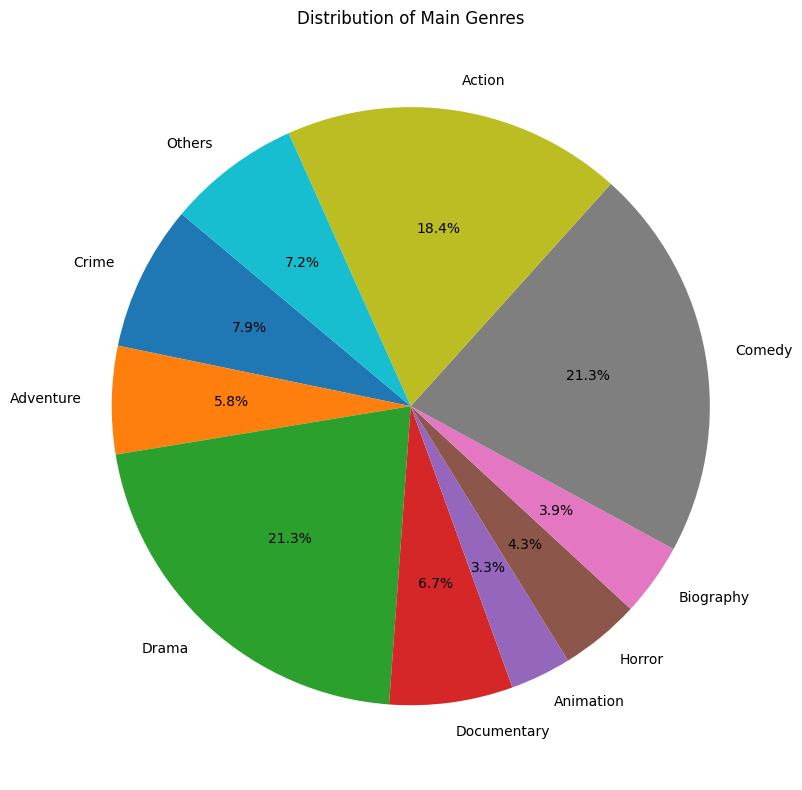

In [20]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Count occurrences of each genre in genre1
genre1_counts = all_data.groupBy("genre1").count()

# Convert to pandas for further manipulation
genre1_counts_pd = genre1_counts.toPandas().set_index("genre1")

# Calculate the threshold and group genres below 3% into 'Others'
threshold = 0.03 * genre1_counts_pd['count'].sum()
genre1_counts_modified = genre1_counts_pd[genre1_counts_pd['count'] >= threshold]
genre1_counts_modified.loc['Others'] = genre1_counts_pd[genre1_counts_pd['count'] < threshold].sum()

# Plot the pie chart for genre1 with 'Others' included
plt.figure(figsize=(10, 8))
plt.pie(genre1_counts_modified['count'], labels=genre1_counts_modified.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Main Genres')
plt.tight_layout()
plt.show()

##### 4. Average IMDb rating by platform

The results show how platforms compare in terms of the average quality of their content based on viewer ratings. These average IMDb ratings highlight how different platforms fare in terms of viewer satisfaction, potentially influencing future content production and acquisition strategies.

The bar chart shows the average IMDb ratings for content on various platforms. HBO leads with an average rating of approximately 6.78, indicating that it consistently offers highly-rated content. Hulu, Netflix, and AppleTV have similar average ratings ranging from about 6.47 to 6.76, suggesting comparable quality among these platforms. Amazon trails with an average rating of approximately 6.02, which is notably lower than the others.

+-------+----------------------+
|Company|avg(imdbAverageRating)|
+-------+----------------------+
|    HBO|     6.782060912306097|
|   Hulu|    6.7055128241196655|
|Netflix|       6.5290979742174|
|AppleTV|     6.478445484919671|
| Amazon|     6.021939307865038|
+-------+----------------------+



<Figure size 1000x600 with 0 Axes>

<BarContainer object of 5 artists>

Text(0.5, 0, 'Platform')

Text(0, 0.5, 'Average IMDb Rating')

Text(0.5, 1.0, 'Average IMDb Rating by Platform')

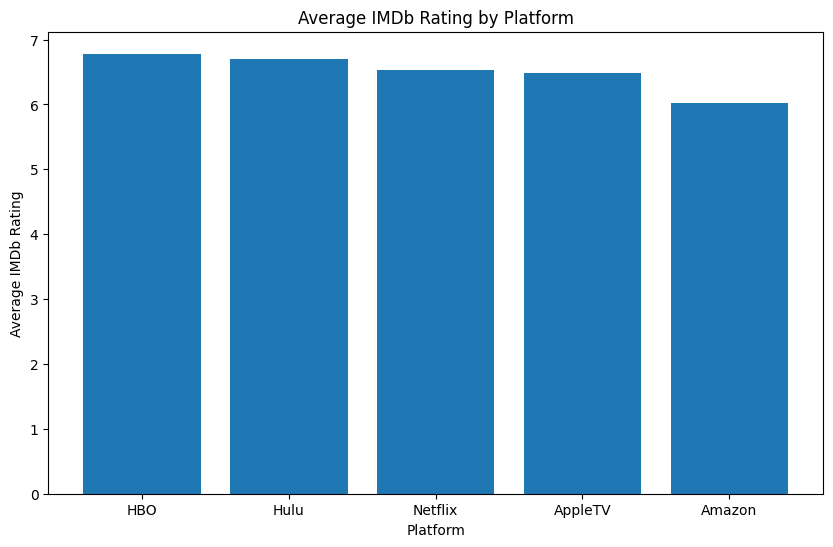

In [21]:
from pyspark.sql.functions import col

# Convert imdbAverageRating to float type
all_data = all_data.withColumn("imdbAverageRating", col("imdbAverageRating").cast("float"))

# Calculate the average IMDb rating by platform (Company)
avg_rating_by_platform = all_data.groupBy("Company").avg("imdbAverageRating").orderBy("avg(imdbAverageRating)", ascending=False)
avg_rating_by_platform.show()

avg_rating_by_platform_pd = avg_rating_by_platform.toPandas()

import matplotlib.pyplot as plt

# Plot Average Rating by Platform
plt.figure(figsize=(10, 6))
plt.bar(avg_rating_by_platform_pd['Company'], avg_rating_by_platform_pd['avg(imdbAverageRating)'])
plt.xlabel('Platform')
plt.ylabel('Average IMDb Rating')
plt.title('Average IMDb Rating by Platform')
plt.show()


##### 5. Top 10 Movies by IMDb Average Rating Across All Platforms

The table shows the top 10 movies by IMDb average rating across different platforms. Notably, Amazon dominates this list with highly-rated documentaries like Rumba in the Jungle and The Lost Spirits, showing that niche, high-quality documentaries can achieve excellent viewer ratings. The list also includes content from Netflix and HBO, highlighting that different platforms can achieve top ratings with distinct content types, such as crime dramas and nature documentaries.

Platforms should take note of the types of content that achieve the highest ratings
For Amazon, investing further in high-quality documentaries can solidify its reputation in this genre. 


In [15]:
top_movies = all_data.filter(all_data["type"] == 1).orderBy("imdbAverageRating", ascending=False).limit(10)
top_movies.show()

+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+-----------+------+------+
|               title|type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|     genre1|genre2|genre3|
+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+-----------+------+------+
|Rumba in the Jung...|   1|       2018|              9.9|        10.0| Amazon|                7|        2010s|Documentary|   NEG|   NEG|
|    The Lost Spirits|   1|       2009|              9.8|        10.0| Amazon|                3|        2000s|Documentary|   NEG|   NEG|
|The Trash Goes Ou...|   1|       2024|              9.8|        18.0| Amazon|                3|        2020s|Documentary|   NEG|   NEG|
|      The Chemo Club|   1|       2016|              9.7|        27.0| Amazon|                3|        2010s|     Comedy|   NEG|   NEG|
|El Comando del Di...|   1|       2013|  

In [16]:
top_movies = all_data.filter(all_data["type"] == 0).orderBy("imdbAverageRating", ascending=False).limit(10)
top_movies.show()


+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+-----------+------------+---------+
|               title|type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|     genre1|      genre2|   genre3|
+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+-----------+------------+---------+
|        Breaking Bad|   0|       2008|              9.5|   2222701.0|Netflix|              121|        2000s|      Crime|       Drama| Thriller|
|     Planet Earth II|   0|       2016|              9.5|    161347.0|    HBO|                7|        2010s|Documentary|         NEG|      NEG|
|      Benjamin Cello|   0|       2019|              9.5|        25.0| Amazon|                2|        2010s|     Family|         NEG|      NEG|
|The Tragically Hi...|   0|       2024|              9.5|       447.0| Amazon|              109|        2020s|  Biography| D

##### 6. Top 10 Genres by Count Across All Platforms

The bar chart illustrates the top 10 genres by frequency across all platforms. Comedy and Drama are the leading genres, followed by Action and Crime. This shows that most platforms prioritize content in these popular genres to cater to broad audience preferences. Niche genres like Biography, Animation, and Reality-TV are represented less, indicating either lower production volumes or more targeted audiences.

+-----------+-----+
|     genre1|count|
+-----------+-----+
|     Comedy|17964|
|      Drama|17950|
|     Action|15506|
|      Crime| 6645|
|Documentary| 5641|
|  Adventure| 4928|
|     Horror| 3662|
|  Biography| 3317|
|  Animation| 2776|
| Reality-TV| 1542|
+-----------+-----+



<Figure size 1000x600 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Genre')

Text(0.5, 1.0, 'Top 10 Genres Across All Platforms')

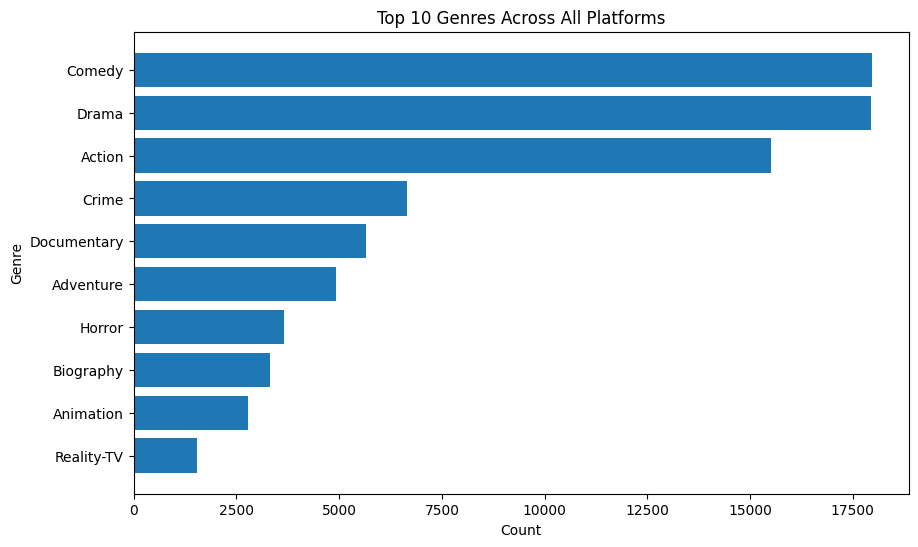

In [23]:
top_genres = all_data.groupBy("genre1").count().orderBy("count", ascending=False).limit(10)
top_genres.show()

top_genres_pd = top_genres.toPandas()

import matplotlib.pyplot as plt

# Plot Top Genres
plt.figure(figsize=(10, 6))
plt.barh(top_genres_pd['genre1'], top_genres_pd['count'])
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Genres Across All Platforms')
plt.gca().invert_yaxis()
plt.show()


##### 7. Analyze Data for Netflix

This section highlights the average number of votes per platform, providing insights into user engagement and the popularity of content on Netflix.

The top-rated movies on Netflix include highly acclaimed series like Breaking Bad and Band of Brothers, as well as classics like The Shawshank Redemption. These top entries show that high ratings are often associated with content that is either highly engaging or timeless. The most frequent genres on Netflix are Comedy, Drama, and Action, indicating Netflix's emphasis on diverse and popular content categories. The average IMDb rating for Netflix content stands at approximately 6.53, which is in line with industry averages, but lower than platforms like HBO.

Netflix should continue investing in top-performing genres such as Crime and Drama, as these have proven to attract large audiences and high ratings. Additionally, focusing on producing or acquiring standout series and movies that align with viewer preferences could enhance overall platform ratings.

In [24]:
# Filter data for Netflix
netflix_data = all_data.filter(all_data.Company == "Netflix")

# Top 10 Netflix Movies by IMDb Average Rating
top_netflix_movies = netflix_data.orderBy("imdbAverageRating", ascending=False).limit(10)
top_netflix_movies.show()

# Most Common Genres on Netflix
netflix_genres = netflix_data.groupBy("genre1").count().orderBy("count", ascending=False).limit(10)
netflix_genres.show()

# Average IMDb Rating for Netflix Content
avg_netflix_rating = netflix_data.agg({"imdbAverageRating": "avg"}).show()


+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+-----------+----------+----------+
|               title|type|releaseYear|imdbAverageRating|imdbNumVotes|Company|NumberOfCountries|releaseDecade|     genre1|    genre2|    genre3|
+--------------------+----+-----------+-----------------+------------+-------+-----------------+-------------+-----------+----------+----------+
|        Breaking Bad|   0|       2008|              9.5|   2222701.0|Netflix|              121|        2000s|      Crime|     Drama|  Thriller|
|    Band of Brothers|   0|       2001|              9.4|    543177.0|Netflix|               53|        2000s|      Drama|   History|       War|
|The Shawshank Red...|   1|       1994|              9.3|   2954554.0|Netflix|               23|        1990s|      Drama|       NEG|       NEG|
|Avatar: The Last ...|   0|       2005|              9.3|    387280.0|Netflix|               98|        2000s|     Action| Adventu

##### 8. Detailed Genre Analysis Across Platforms


he table shows the genre distribution across different platforms, with Netflix leading in genres like Comedy, Drama, and Action. This indicates that Netflix prioritizes content that appeals to a broad audience, while other genres such as Musical and Sci-Fi are less represented. 

 Platforms could identify opportunities to expand their content libraries by focusing on underrepresented genres to capture niche audiences and differentiate their offerings.

In [25]:
# Group by platform and genre to count occurrences
genre_distribution = all_data.groupBy("Company", "genre1").count().orderBy("Company", "count", ascending=False)
genre_distribution.show()


+-------+-----------+-----+
|Company|     genre1|count|
+-------+-----------+-----+
|Netflix|     Comedy| 3769|
|Netflix|      Drama| 2709|
|Netflix|     Action| 2606|
|Netflix|      Crime| 1091|
|Netflix|  Adventure|  880|
|Netflix|Documentary|  631|
|Netflix|  Biography|  599|
|Netflix|  Animation|  460|
|Netflix|     Horror|  319|
|Netflix| Reality-TV|  181|
|Netflix|  Game-Show|   67|
|Netflix|     Family|   64|
|Netflix|    Romance|   64|
|Netflix|   Thriller|   53|
|Netflix|    Fantasy|   51|
|Netflix|    Mystery|   43|
|Netflix|    Musical|   14|
|Netflix|      Music|   12|
|Netflix|     Sci-Fi|   10|
|Netflix|  Talk-Show|    9|
+-------+-----------+-----+
only showing top 20 rows



#####  9. Release Year Trends


he number of movie releases per decade shows a significant increase from the 1980s onwards, with the 2010s and 2020s having the highest counts. This trend highlights the rapid growth in content production over the past few decades.

Platforms should continue investing in new content production while also maintaining a library of classic films that have retained popularity over time.



In [26]:
# Number of releases per year
releases_per_decade = all_data.groupBy("releaseDecade").count().orderBy("releaseDecade")
releases_per_decade.show()

+-------------+-----+
|releaseDecade|count|
+-------------+-----+
|        1890s|    1|
|        1900s|   10|
|        1910s|   40|
|        1920s|  165|
|        1930s|  826|
|        1940s| 1077|
|        1950s| 1820|
|        1960s| 2437|
|        1970s| 3449|
|        1980s| 4881|
|        1990s| 6770|
|        2000s|15020|
|        2010s|38843|
|        2020s| 9126|
+-------------+-----+



##### 10. Top Companies by Number of Releases


Amazon has the highest number of releases, followed by Netflix, which aligns with these platforms' strategy to provide a vast range of content. HBO has fewer releases, suggesting a more selective approach to content production. 

Companies with a smaller number of releases like HBO could focus on maintaining high-quality content to compete, while platforms like Amazon and Netflix should analyze viewer engagement metrics to prioritize and promote successful content types

In [27]:
# Top platforms by number of releases
releases_per_platform = all_data.groupBy("Company").count().orderBy("count", ascending=False)
releases_per_platform.show()

+-------+-----+
|Company|count|
+-------+-----+
| Amazon|44222|
|Netflix|13647|
|AppleTV|12647|
|   Hulu| 7020|
|    HBO| 6929|
+-------+-----+



##### 11. Correlation between Rating and Votes

The correlation between IMDb average rating and the number of votes is approximately 0.20, indicating a weak positive correlation. This suggests that while higher-rated movies tend to receive more votes, the relationship is not strong enough to assume a direct link between the two. 

Platforms should promote high-rated content to increase viewer engagement and ratings, but they should also focus on marketing strategies that encourage audience participation and feedback for content with fewer votes.

In [28]:
# Correlation between numerical features
correlation_rating_votes = all_data.stat.corr("imdbAverageRating", "imdbNumVotes")
print(f"Correlation between IMDb average rating and number of votes: {correlation_rating_votes}")

Correlation between IMDb average rating and number of votes: 0.20404805665286863


##### 12. Top-rated content by genre

The top-rated genres include Documentary, Comedy, and Crime, all with maximum IMDb ratings above 9.0. This highlights that these genres are well-received and often deliver exceptional content that garners high user satisfaction.

Platforms should prioritize acquiring or producing content in these high-rated genres to attract audiences looking for top-quality entertainment.

In [21]:
# Max rating per genre
top_ratings_per_genre = all_data.groupBy("genre1").agg(F.max("imdbAverageRating").alias("max_imdbRating"))

# Join count movies with max rating
top_rated_per_genre = top_ratings_per_genre.join(
    all_data,
    (all_data["genre1"] == top_ratings_per_genre["genre1"]) & (all_data["imdbAverageRating"] == top_ratings_per_genre["max_imdbRating"]),
    "inner"
).groupBy(top_ratings_per_genre["genre1"], "max_imdbRating").count().withColumnRenamed("count", "num_movies")

top_rated_per_genre.orderBy("max_imdbRating", ascending=False).show()


+-----------+--------------+----------+
|     genre1|max_imdbRating|num_movies|
+-----------+--------------+----------+
|Documentary|           9.9|         1|
|     Comedy|           9.7|         1|
|     Action|           9.5|         1|
|  Biography|           9.5|         1|
|      Crime|           9.5|         1|
|     Family|           9.5|         1|
|      Drama|           9.4|         4|
|    History|           9.4|         1|
|       Kids|           9.4|         1|
| Reality-TV|           9.4|         2|
|      Sport|           9.4|         1|
|  Adventure|           9.3|         1|
|  Animation|           9.3|         1|
|      Adult|           9.2|         1|
|    Reality|           9.2|         1|
|      Music|           9.1|         1|
|        NEG|           9.1|         1|
|  Talk-Show|             9|         1|
|    Romance|           8.9|         1|
|   Thriller|           8.8|         1|
+-----------+--------------+----------+
only showing top 20 rows



##### 13.Average number of votes per platform

HBO has the highest average number of votes per movie, suggesting a strong viewer base for its content, followed by Hulu and Netflix. Amazon has the lowest average number of votes, indicating potentially lower engagement or fewer widely recognized titles.

Platforms like Amazon could benefit from boosting viewer interaction and visibility for their content through strategic marketing and partnerships. HBO and Hulu should maintain their current strategies that drive viewer interest, while Netflix could focus on leveraging popular titles to sustain or increase its vote averages.

In [30]:
# Average number of votes per platform
avg_votes_per_platform = all_data.groupBy("Company").avg("imdbNumVotes").orderBy("avg(imdbNumVotes)", ascending=False)
avg_votes_per_platform.show()

+-------+------------------+
|Company| avg(imdbNumVotes)|
+-------+------------------+
|    HBO| 68751.80632125848|
|   Hulu| 43769.74017094017|
|Netflix| 41676.82545614421|
|AppleTV|30861.936348541156|
| Amazon|17440.991814029217|
+-------+------------------+



##### EDA Conclusion

The EDA conducted on the merged dataset of movies across different streaming platforms has revealed significant insights into content trends, audience engagement, and platform-specific strengths. 

**Key takeaways** 
- the dominance of popular genres like Comedy, Drama, and Action, which attract large audience
- the presence of high-rated content in genres such as Documentary and Crime.
- Platforms like HBO and Netflix have consistently high average IMDb ratings and viewer engagement
- Amazon show room for growth in content quality and audience interaction.
- There is some relationship between movie ratings and the number of votes, it is not strong enough to make direct assumptions. 
- Highlight of the rapid increase in content production in recent decades

**Recommendations** 
- **Diversify Content Offerings:** Platforms should focus on diversifying their content libraries by exploring underrepresented but high-rated genres, such as Biography and Family, to capture niche audiences and differentiate themselves.
- **Invest in High-Quality Productions:** Emphasize investing in genres that are consistently high-rated, like Documentaries and Crime, to attract audiences seeking top-quality content.
- **Promote Engagement:** Platforms with lower average votes, such as Amazon, should develop marketing strategies to increase viewer engagement and ratings. 
- **Leverage Data-Driven Content Acquisition:** Use insights from the EDA to inform decisions on content acquisition and production. Focus on genres and types of content that have historically performed well in terms of ratings and viewer engagement.
- **Balance Between Popular and Niche Content:** While it’s important to invest in popular genres, offering niche content can help platforms attract specific audience segments and boost retention.